In [1]:
import tensorflow as tf
import numpy as np
import keras
from sklearn.model_selection import train_test_split

#加载mnist数据集
(x_train0, y_train0), (x_test0, y_test0) = tf.keras.datasets.mnist.load_data()
#预处理
x_train, x_test = x_train0.astype(np.float32)/255., x_test0.astype(np.float32)/255.
x_train, x_test = np.expand_dims(x_train, axis=3), np.expand_dims(x_test, axis=3)
# 创建训练集50000、验证集10000以及测试集10000
#x_val = x_train[-10000:]
#y_val = y_train0[-10000:]
#x_train = x_train[:-10000]
#y_train = y_train0[:-10000]
x_train, x_val, y_train, y_val =train_test_split(x_train,y_train0,test_size = 0.2)
#标签转为one-hot格式
y_train = tf.one_hot(y_train, depth=10).numpy()
y_val = tf.one_hot(y_val, depth=10).numpy()
y_test = tf.one_hot(y_test0, depth=10).numpy()

# tf.data.Dataset 批处理
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(100).repeat()
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(100).repeat()
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(100).repeat()

# 3x3 convolution
def conv3x3(channels, stride=1, kernel=(3, 3)):
    return keras.layers.Conv2D(channels, kernel, strides=stride, padding='same',
                               use_bias=False,
                            kernel_initializer=tf.random_normal_initializer())

class ResnetBlock(keras.Model):
    def __init__(self, channels, strides=1, residual_path=False):
        super(ResnetBlock, self).__init__()
        self.channels = channels
        self.strides = strides
        self.residual_path = residual_path
        self.conv1 = conv3x3(channels, strides)
        self.bn1 = keras.layers.BatchNormalization()
        self.conv2 = conv3x3(channels)
        self.bn2 = keras.layers.BatchNormalization()
        if residual_path:
            self.down_conv = conv3x3(channels, strides, kernel=(1, 1))
            self.down_bn = tf.keras.layers.BatchNormalization()

    def call(self, inputs, training=None):
        residual = inputs
        x = self.bn1(inputs, training=training)
        x = tf.nn.relu(x)
        x = self.conv1(x)
        x = self.bn2(x, training=training)
        x = tf.nn.relu(x)
        x = self.conv2(x)

        # this module can be added into self.
        # however, module in for can not be added.
        if self.residual_path:
            residual = self.down_bn(inputs, training=training)
            residual = tf.nn.relu(residual)
            residual = self.down_conv(residual)
        x = x + residual
        return x

class ResNet(keras.Model):
    def __init__(self, block_list, num_classes, initial_filters=16, **kwargs):
        super(ResNet, self).__init__(**kwargs)
        self.num_blocks = len(block_list)
        self.block_list = block_list

        self.in_channels = initial_filters
        self.out_channels = initial_filters
        self.conv_initial = conv3x3(self.out_channels)
        self.blocks = keras.models.Sequential(name='dynamic-blocks')
        # build all the blocks
        for block_id in range(len(block_list)):
            for layer_id in range(block_list[block_id]):
                if block_id != 0 and layer_id == 0:
                    block = ResnetBlock(self.out_channels, strides=2, residual_path=True)
                else:
                    if self.in_channels != self.out_channels:
                        residual_path = True
                    else:
                        residual_path = False
                    block = ResnetBlock(self.out_channels, residual_path=residual_path)
                self.in_channels = self.out_channels
                self.blocks.add(block)
            self.out_channels *= 2
        self.final_bn = keras.layers.BatchNormalization()
        self.avg_pool = keras.layers.GlobalAveragePooling2D()
        self.fc = keras.layers.Dense(num_classes, activation='softmax')

    def call(self, inputs, training=None):
        out = self.conv_initial(inputs)
        out = self.blocks(out, training=training)
        out = self.final_bn(out, training=training)
        out = tf.nn.relu(out)
        out = self.avg_pool(out)
        out = self.fc(out)
        return out
        
#网络参数设置
resnet_model = ResNet([2, 2, 2], 10)
resnet_model.compile(optimizer=keras.optimizers.Adam(0.001),
              loss='categorical_crossentropy',
              metrics=['acc'])
              
resnet_model.build(input_shape=(None, 28, 28, 1))


### 不同ResNet网络的层次需求
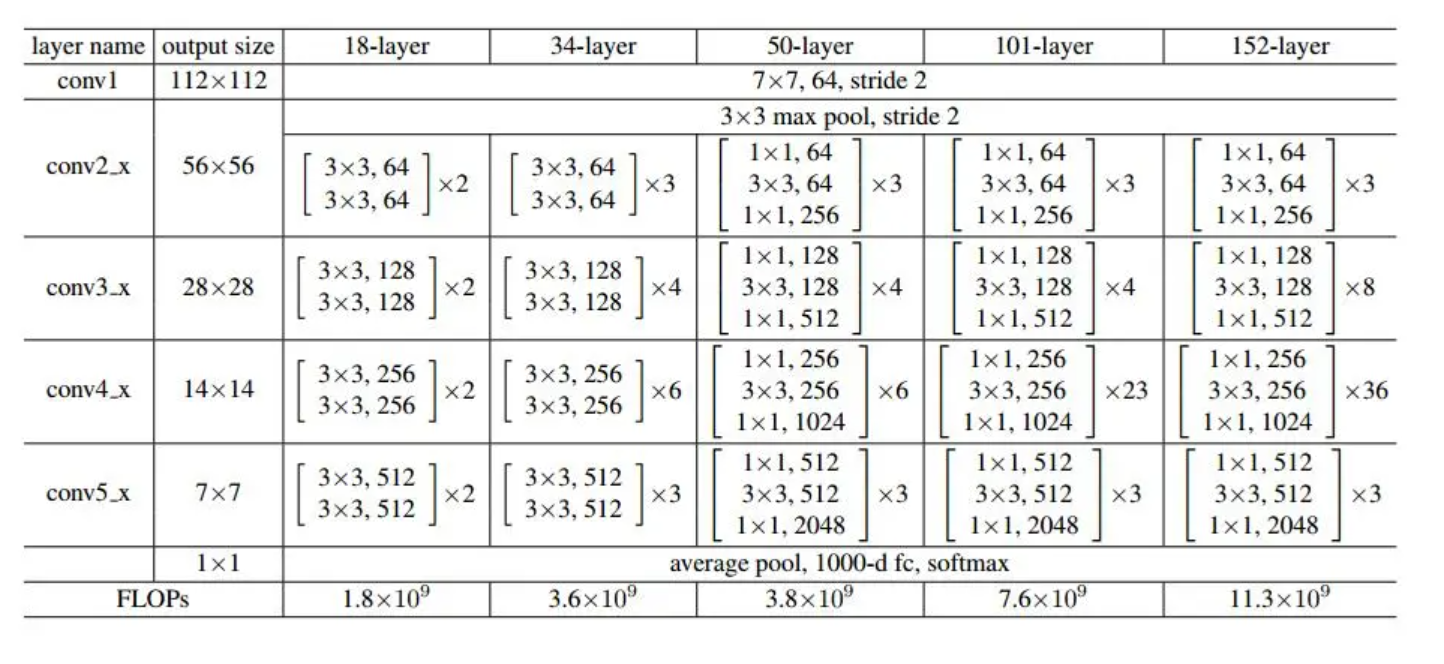

### resnet 结构
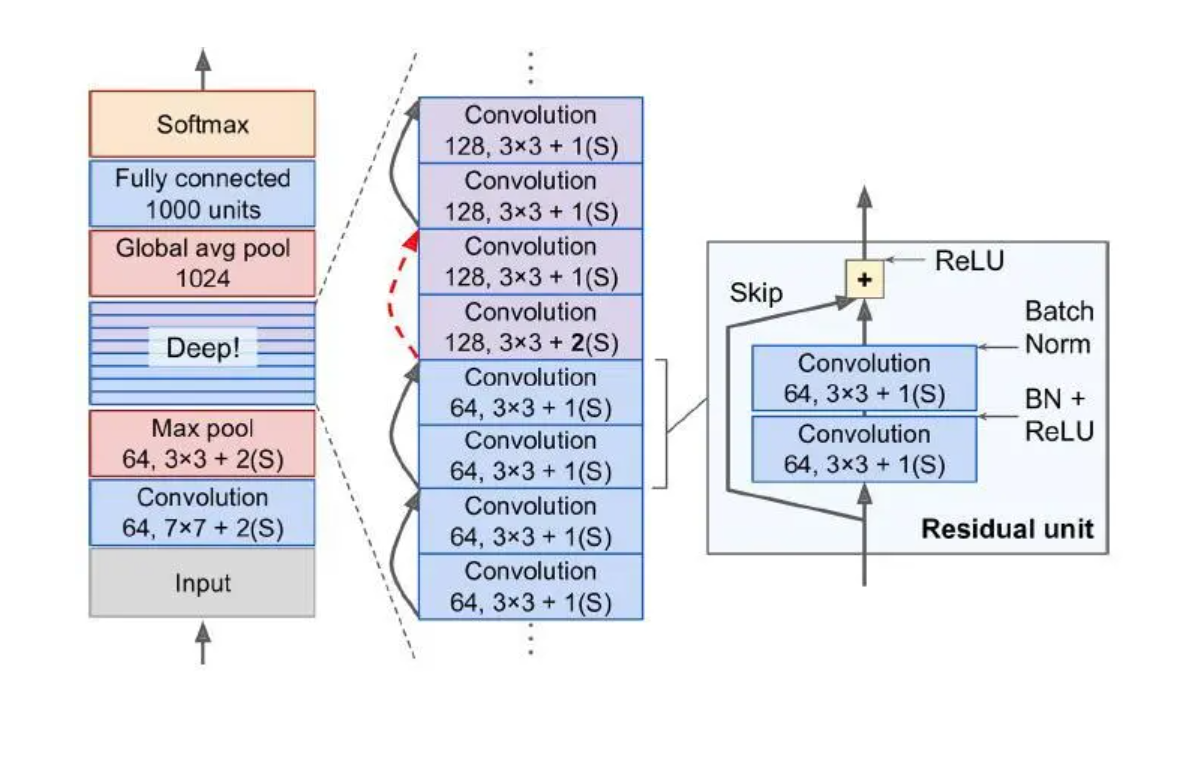

In [2]:
#打印网络参数
print("Number of variables in the model :", len(resnet_model.variables))
resnet_model.summary()

Number of variables in the model : 77
Model: "res_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  144       
                                                                 
 dynamic-blocks (Sequential)  (None, 7, 7, 64)         174848    
                                                                 
 batch_normalization_14 (Bat  multiple                 256       
 chNormalization)                                                
                                                                 
 global_average_pooling2d (G  multiple                 0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               multiple                  650       
                                                                 
Total params: 175,898

Epoch 1/100
50/50 [==============================] - 15s 248ms/step - loss: 1.1383 - acc: 0.6992 - val_loss: 4.2890 - val_acc: 0.0933
Epoch 2/100
50/50 [==============================] - 12s 249ms/step - loss: 0.2242 - acc: 0.9632 - val_loss: 5.9915 - val_acc: 0.0933
Epoch 3/100
50/50 [==============================] - 13s 254ms/step - loss: 0.1427 - acc: 0.9712 - val_loss: 9.5137 - val_acc: 0.0933
Epoch 4/100
50/50 [==============================] - 12s 248ms/step - loss: 0.1165 - acc: 0.9742 - val_loss: 5.5885 - val_acc: 0.0933
Epoch 5/100
50/50 [==============================] - 12s 249ms/step - loss: 0.0920 - acc: 0.9784 - val_loss: 3.3169 - val_acc: 0.2000
Epoch 6/100
50/50 [==============================] - 13s 250ms/step - loss: 0.0841 - acc: 0.9788 - val_loss: 5.7092 - val_acc: 0.1467
Epoch 7/100
50/50 [==============================] - 13s 250ms/step - loss: 0.0706 - acc: 0.9832 - val_loss: 5.3740 - val_acc: 0.1500
Epoch 8/100
50/50 [==============================] - 13s 261ms

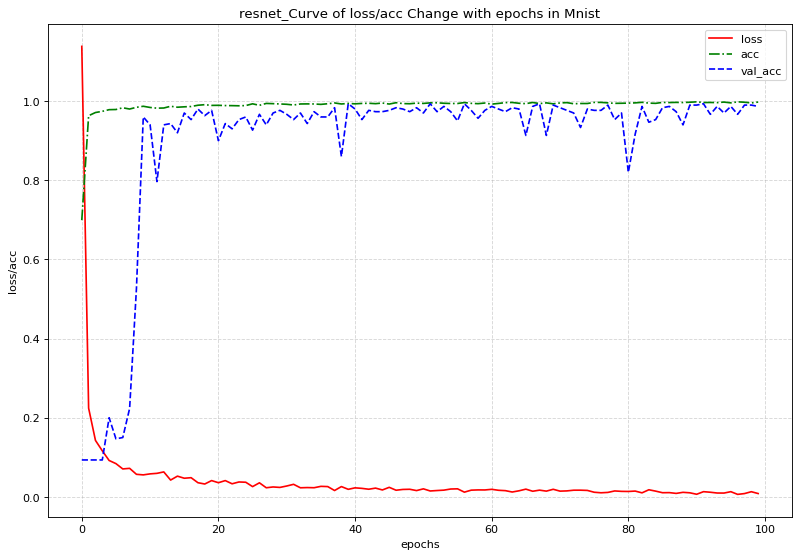

In [3]:
import matplotlib.pyplot as plt
#开始训练
history_resnet = resnet_model.fit(train_dataset, epochs=100, steps_per_epoch=50, validation_data=val_dataset, validation_steps=3)
#测试集评估及保存权重
resnet_model.evaluate(test_dataset, steps=100)
resnet_model.save_weights('saved_model/resnet_mnist/resnet_mnist_weights.ckpt')

#输入两个曲线的信息
plt.figure( figsize=(12,8), dpi=80 )
plt.plot(history_resnet.epoch, history_resnet.history.get('loss'), color='r', label = 'loss')
plt.plot(history_resnet.epoch, history_resnet.history.get('acc'), color='g', linestyle='-.', label = 'acc')
plt.plot(history_resnet.epoch, history_resnet.history.get('val_acc'), color='b', linestyle='--', label = 'val_acc')

#显示图例
plt.legend() #默认loc=Best
#添加网格信息
plt.grid(True, linestyle='--', alpha=0.5) #默认是True，风格设置为虚线，alpha为透明度
#添加标题
plt.xlabel('epochs')
plt.ylabel('loss/acc')
plt.title('resnet_Curve of loss/acc Change with epochs in Mnist')
plt.savefig('./save_png/resnet.png')
plt.show()

In [2]:
resnet_model.load_weights('saved_model/resnet_mnist/resnet_mnist_weights.ckpt')
predictions = resnet_model.predict(test_dataset,steps=1,verbose=0)

In [3]:
pred = np.argmax(predictions, axis=1)
print(pred)

[7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1 3 1 3 4 7 2 7
 1 2 1 1 2 4 2 3 5 1 2 4 4 6 3 5 5 6 0 4 1 9 5 7 8 9 3 7 4 6 4 3 0 7 0 2 9
 1 7 3 2 9 7 7 6 2 7 8 4 7 3 6 1 3 6 4 3 1 4 1 7 6 9]


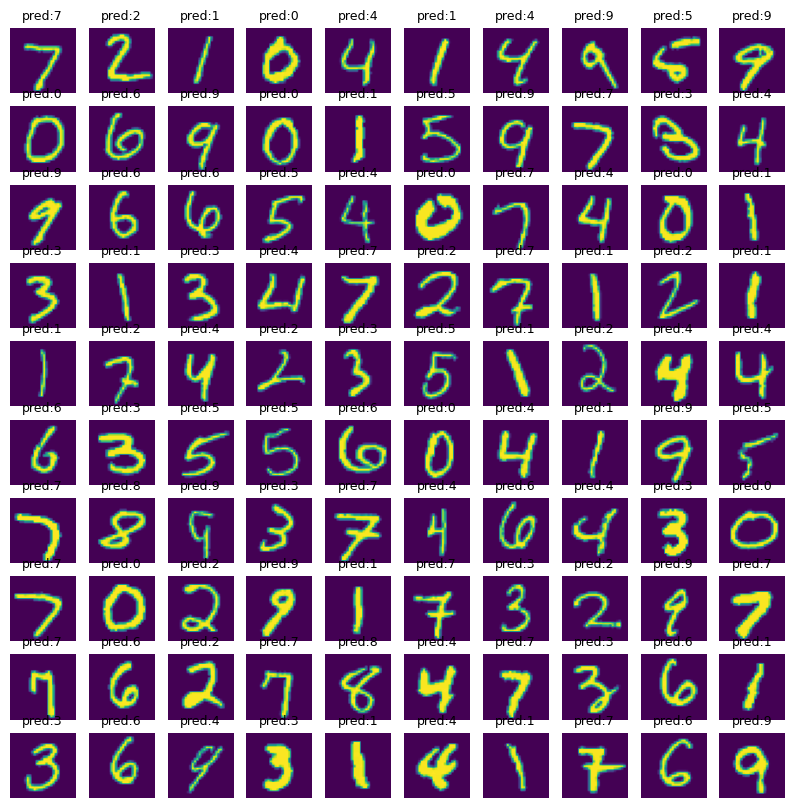

In [4]:
import matplotlib.pyplot as plt
#plt.imshow(x_train0[0])
x = x_test0
cnt = 0
ROWS = 10
fig, axes1 = plt.subplots(ROWS,ROWS,figsize=(10,10))
for j in range(ROWS):
    for k in range(ROWS):
        axes1[j][k].set_axis_off()
        axes1[j][k].set_title(f'pred:{pred[cnt]}',fontsize = 9)
        #plt.suptitle(f'{pred[cnt]}')
        axes1[j][k].imshow(x[cnt:cnt+1][0])
        cnt = cnt + 1